In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.time import Time, TimezoneInfo
from datetime import datetime
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun, Angle
from astropy.table import Table
import os, re

import urllib2
# %matplotlib inline

import requests
from PIL import Image
from io import BytesIO

In [2]:
## Download PANSTARR data

def getimages(ra,dec,size=240,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False)
        ax.axis('off')

## Changing the naming convention to CHIPSra+dec

In [6]:
df=pd.read_csv('/Users/taweewat/Dropbox/Documents/MIT/Observation/2017_1/all_objs.csv')
df['name']

ra_l=[Angle(i, u.deg).to_string(unit=u.hr, sep='', precision=0, pad=True)[:4] for i in df['ra'].values]
dec_l=[Angle(i, u.deg).to_string(unit=u.degree, sep='', precision=0, alwayssign=True, pad=True)[:5] for i in df['dec'].values]

df['chips']=['CHIPS'+i+j for i, j in zip(ra_l, dec_l)]
# df=df[['name','chips']]
# df[['name','chips']].sort_values(by='chips').to_csv('/Users/taweewat/Dropbox/Documents/MIT/Observation/chips_name_old.csv')

In [3]:
dfq=pd.read_csv('/Users/taweewat/Documents/xray_project/ned-result/final_cut7_new.csv')   #final_cut7_new.csv (already remove mike previous observations)
# dfq=dfq.set_index([np.arange(1,722+1,1).tolist()])

print dfq.shape

ra_l=[Angle(i, u.deg).to_string(unit=u.hr, sep='', precision=0, pad=True)[:4] for i in dfq['ra'].values]
dec_l=[Angle(i, u.deg).to_string(unit=u.degree, sep='', precision=0, alwayssign=True, pad=True)[:5] for i in dfq['dec'].values]

dfq['chips']=['CHIPS'+i+j for i, j in zip(ra_l, dec_l)]
# dfq.sort_values(by='chips').to_csv('/Users/taweewat/Dropbox/Documents/MIT/Observation/chips_name_new.csv')

(777, 67)


In [4]:
dfq.head()

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,exray,emir,eradio,redshift,sep,type,SDSS,reject,followup,chips
0,6.526185,-8.858947,133.04916,76.45306,133.047968,76.454851,0.0422,0.0421,-0.0066,13.827,...,0.133939,0.070364,0.054538,1.127,7.2,G,no,reject,outSD/outside,CHIPS0852+7627
1,1.098727,-83.546683,34.37958,73.82569,34.378491,73.825724,0.0482,0.0477,-0.0040,14.024,...,0.116648,0.070748,0.062726,2.367,1.2,QSO,yes,reject,inSD/outside,CHIPS0217+7349
2,6.014274,151.687668,137.11916,72.27611,137.121762,72.274639,0.0444,0.0444,-0.0020,14.167,...,0.165112,0.089741,0.079033,-1.000,-1.0,NaN,no,not_reject,follow,CHIPS0908+7216
3,6.771788,-26.052877,156.65541,70.54361,156.652929,70.545300,0.0482,0.0488,0.0041,14.223,...,0.172692,0.092658,0.079065,-1.000,-1.0,NaN,no,not_reject,follow,CHIPS1026+7032
4,11.401083,168.222225,114.08708,65.22320,114.088622,65.220100,0.0653,0.0663,0.0023,14.722,...,0.211735,0.111482,0.073924,3.035,11.8,QSO,yes,reject,inSD/outside,CHIPS0736+6513


In [7]:
intersect=np.intersect1d(df['chips'].values, dfq['chips'].values)
df_new=df[df['chips'].isin(intersect)]
print len(df_new)

227


In [28]:
home='/Users/taweewat/Documents/pisco_code/'
dirs=['ut170103/','ut170104/','ut170619/','ut170621/','ut170624/','ut171208/','ut171209/','ut171212/','ut190412','ut190412','ut190413']
names=[]
myReg=re.compile(r'(CHIPS\d{4}[+-]\d{4})|(Field\d{3})')
for di in dirs:
    dir=home+di
    for text in os.listdir(dir):
        if myReg.search(text) != None:
            names.append(myReg.search(text).group())
all_fields=list(set(names))
all_fields=np.array(all_fields)

In [29]:
#rename Field to CHIPS
df=pd.read_csv('/Users/taweewat/Dropbox/Documents/MIT/Observation/2017_1/all_objs.csv')
ra_l=[Angle(i, u.deg).to_string(unit=u.hr, sep='', precision=0, pad=True)[:4] for i in df['RA0'].values]
dec_l=[Angle(i, u.deg).to_string(unit=u.degree, sep='', precision=0, alwayssign=True, pad=True)[:5] for i in df['DEC0'].values]
df['chips']=['CHIPS'+i+j for i, j in zip(ra_l, dec_l)]

In [30]:
for index, i in enumerate(all_fields):
    if i[:5]=='Field':
        print i, df[df['name']==all_fields[index]]['chips'].values[0]
        all_fields[index]=str(df[df['name']==all_fields[index]]['chips'].values[0])

Field143 CHIPS0118-1843
Field099 CHIPS0143-4424
Field097 CHIPS2244-4002
Field094 CHIPS2155-3727
Field092 CHIPS1354-3648
Field091 CHIPS1045-3752
Field039 CHIPS1715-0953
Field135 CHIPS0057-4158
Field136 CHIPS0103-6439
Field137 CHIPS0104-7201
Field132 CHIPS0024-2928
Field028 CHIPS0512-0358
Field029 CHIPS1338-0627
Field225 CHIPS1354-2001
Field226 CHIPS1356-7406
Field227 CHIPS1401-2322
Field022 CHIPS1830+1141
Field229 CHIPS1436-1613
Field020 CHIPS1712+1705
Field021 CHIPS1735+1935
Field026 CHIPS0332-0347
Field027 CHIPS0336-0506
Field024 CHIPS0448-0155
Field025 CHIPS1701+0207
Field048 CHIPS1453-1912
Field124 CHIPS2258-7014
Field123 CHIPS0340-6703
Field121 CHIPS2245-5955
Field040 CHIPS2246-1207
Field042 CHIPS0105-1801
Field044 CHIPS0208-1739
Field045 CHIPS0939-1858
Field046 CHIPS1404-1424
Field047 CHIPS1352-1817
Field058 CHIPS1046-2119
Field222 CHIPS1344-0924
Field233 CHIPS1701-0643
Field230 CHIPS1454-3747
Field237 CHIPS1743+2752
Field038 CHIPS1513-0906
Field234 CHIPS1736+3441
Field034 CHIPS03

In [18]:
all_fields.shape

(260,)

In [19]:
dfq['pisco']=np.where(dfq['chips'].isin(all_fields),True,False)

In [24]:
dfq[dfq['chips']=='CHIPS1102-3031']

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,emir,eradio,redshift,sep,type,SDSS,reject,followup,chips,pisco
260,5.699766,-44.084024,165.60875,-30.52458,165.607471,-30.523443,0.0882,0.0945,0.0205,15.408,...,0.123218,0.089583,-1.0,-1.0,NaN,no,not_reject,follow,CHIPS1102-3031,True


In [21]:
dfq[dfq['pisco']]

,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,w1mpro,...,emir,eradio,redshift,sep,type,SDSS,reject,followup,chips,pisco
114,17.454417,-113.340545,260.39334,21.18569,260.388566,21.183769,0.0459,0.0467,-0.0067,13.975,...,0.099142,0.074289,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS1721+2111,True
130,6.916853,-30.733450,258.03043,17.09667,258.029403,17.098322,0.0663,0.0682,-0.0066,15.027,...,0.138555,0.107871,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS1712+1705,True
131,11.189878,-148.802268,263.84042,19.59250,263.838711,19.589841,0.0429,0.0420,0.0052,13.967,...,0.086310,0.082772,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS1735+1935,True
167,7.223378,113.217382,92.31417,-2.79694,92.316016,-2.797731,0.1092,0.1153,-0.0210,15.343,...,0.154896,0.096027,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS0609-0247,True
178,9.272112,-147.673201,53.24250,-3.78306,53.241120,-3.785236,0.0408,0.0397,0.0029,13.180,...,0.082159,0.069643,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS0332-0347,True
179,14.274639,-121.906078,54.20834,-5.10167,54.204960,-5.103766,0.0634,0.0647,-0.0128,14.608,...,0.182283,0.097048,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS0336-0506,True
180,20.693760,9.356004,116.34625,-7.24722,116.347192,-7.241548,0.0550,0.0606,-0.0158,14.197,...,0.082945,0.060915,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS0745-0714,True
183,8.111056,43.486046,204.53168,-6.45472,204.533240,-6.453085,0.0450,0.0452,-0.0031,13.899,...,0.100505,0.093943,0.625000,9.0,QSO,no,not_reject,follow,CHIPS1338-0627,True
184,14.724889,-177.239387,207.55750,-6.80861,207.557302,-6.812696,0.0457,0.0452,-0.0103,13.561,...,0.093748,0.064934,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS1350-0648,True
189,20.048523,-116.507533,12.61167,-12.01708,12.606575,-12.019566,0.0625,0.0635,-0.0117,14.814,...,0.174522,0.094344,-1.000000,-1.0,NaN,no,not_reject,follow,CHIPS0050-1201,True


In [110]:
panstar_l=[]

for i, row in dfq.iterrows():
    try: 
        ig=getgrayim(row['ra_01'],row['dec_01'],size=960,filter="g")
        panstar_l.append(True)
    except:
        print('no')
        panstar_l.append(False)

no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no


no
no
no
no
no
no
no


no
no
no
no
no


no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no
no


no
no
no
no
no
no
no
no
no
no
no
no
no


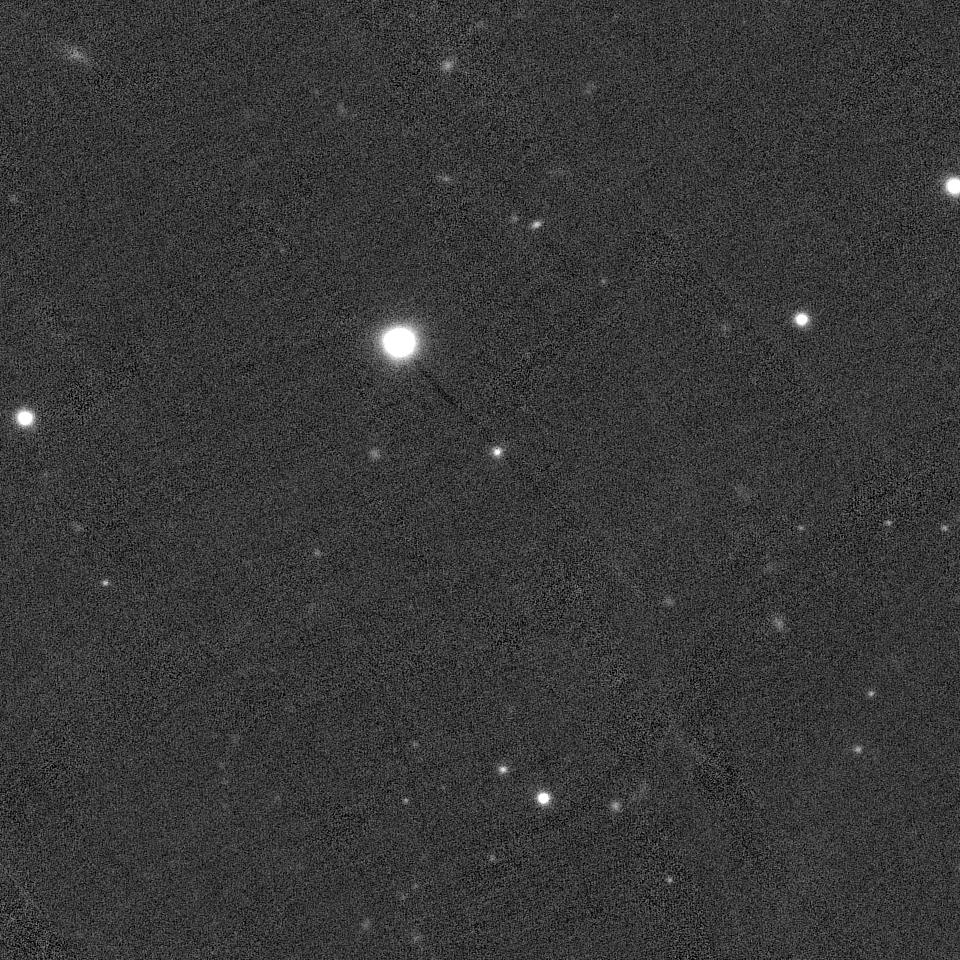

In [115]:
getgrayim(0.38792,14.93375,size=960,filter="g")

In [112]:
dfq['panstar']=panstar_l

In [114]:
dfq.to_csv('/Users/taweewat/Documents/xray_project/ned-result/total_777_new.csv')

In [103]:
ra = 152.86667
dec = 5.09458
size = 960
try: 
    ig=getgrayim(ra,dec,size=size,filter="g")
except:
    print('no')

### Field --> CHIPP Name conversion

In [4]:
df0=pd.read_csv('/Users/taweewat/Documents/red_sequence/chips_all_obj.csv', index_col=0)
df0.head()

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,sep,type,SDSS,reject,followup,chips,priority,panstar,pisco,outside_pisco
3,173,6.014274,151.687668,137.11916,72.27611,137.121762,72.274639,0.0444,0.0444,-0.0020,...,-1.0,NaN,no,not_reject,follow,CHIPS0908+7216,B,True,False,False
4,188,6.771788,-26.052877,156.65541,70.54361,156.652929,70.545300,0.0482,0.0488,0.0041,...,-1.0,NaN,no,not_reject,follow,CHIPS1026+7032,B,True,False,False
9,585,12.770218,-81.392609,98.97625,61.35931,98.968932,61.359841,0.1013,0.1088,-0.0160,...,-1.0,NaN,no,not_reject,follow,CHIPS0635+6121,C,True,False,False
13,725,12.566844,-163.485339,246.80334,60.89944,246.801300,60.896093,0.0395,0.0408,-0.0077,...,-1.0,NaN,no,not_reject,follow,CHIPS1627+6053,B,True,False,False
15,891,17.177243,-3.988254,7.85542,54.98917,7.854841,54.993930,0.0677,0.0649,-0.0122,...,-1.0,NaN,no,not_reject,follow,CHIPS0031+5459,D,True,False,False


In [45]:
df=pd.read_csv('/Users/taweewat/Dropbox/Documents/MIT/Observation/2017_1/all_objs.csv')

ra_l=[Angle(i, u.deg).to_string(unit=u.hr, sep='', precision=0, pad=True)[:4] for i in df['RA0'].values]
dec_l=[Angle(i, u.deg).to_string(unit=u.degree, sep='', precision=0, alwayssign=True, pad=True)[:5] for i in df['DEC0'].values]

df['chips']=['CHIPP'+i+j for i, j in zip(ra_l, dec_l)]
df['chips_new']=['CHIPS'+i+j for i, j in zip(ra_l, dec_l)]

In [19]:
# df.sort_values(by='chips').to_csv('/Users/taweewat/Documents/xray_project/red_sequence/field_chips_all_obj.csv')

In [ ]:
field='cField024_A_82_g'
def ra_dec_field(field):
    de=pd.read_csv('/Users/taweewat/Documents/xray_project/red_sequence/field_chips_all_obj.csv')
    ra=de[de.name==field[1:9]].RA0.values[0]
    dec=de[de.name==field[1:9]].DEC0.values[0]
    return ra, dec
ra_dec_field(field)

In [12]:
field[1:9]

'Field024'

## Already observed

In [15]:
def list_file_name(dir, name, end=0):
    names = []
    for file in os.listdir(dir):
        if file.startswith(name):
            if end == 0:
                names.append(os.path.join(dir, file))
            else:
                if file.endswith(end):
                    names.append(os.path.join(dir, file))
    if len(names) == 0:
        print 'Cannot find the files'
    return names

In [16]:
direc='/Users/taweewat/Documents/pisco_code/'
folders=['ut170103','ut170104','ut170619','ut170621','ut170624']
all_fields=[]
all_sdss=[]
for folder in folders:
    all_fields=all_fields+list(set([i.split('/')[-1].split('_')[0] for i in list_file_name(direc+folder, 'Field')]))
    all_sdss=all_sdss+list(set([i.split('/')[-1].split('_')[0] for i in list_file_name(direc+folder, 'SDSS')]))+\
    list(set([i.split('/')[-1].split('_')[0] for i in list_file_name(direc+folder, 'PKS')]))

Cannot find the files
Cannot find the files
Cannot find the files
Cannot find the files
Cannot find the files
Cannot find the files
Cannot find the files
Cannot find the files


In [17]:
all_fields=list(set(all_fields))
print len(all_fields)

118


In [20]:
intersect_field=np.intersect1d(all_fields, df['name'].values)

In [24]:
df_field=df[df['name'].isin(intersect_field)] 
df_field.shape

(118, 66)

In [25]:
df_field['chips']

17     CHIPP1721+2111
19     CHIPP1712+1705
20     CHIPP1735+1935
21     CHIPP1830+1141
23     CHIPP0448-0155
24     CHIPP1701+0207
25     CHIPP0332-0347
26     CHIPP0336-0506
27     CHIPP0512-0358
28     CHIPP1338-0627
29     CHIPP0050-1201
32     CHIPP0340-0907
33     CHIPP0329-1003
35     CHIPP0856-1105
36     CHIPP1302-0901
37     CHIPP1513-0906
38     CHIPP1715-0953
39     CHIPP2246-1207
41     CHIPP0105-1801
43     CHIPP0208-1739
44     CHIPP0939-1858
45     CHIPP1404-1424
46     CHIPP1352-1817
47     CHIPP1453-1912
51     CHIPP2348-1631
52     CHIPP0258-2431
53     CHIPP0311-2201
54     CHIPP0413-1947
55     CHIPP0858-2232
56     CHIPP0948-2211
            ...      
197    CHIPP0819-0756
200    CHIPP0828-2553
201    CHIPP0841-7540
203    CHIPP0857-7719
204    CHIPP0927-2034
205    CHIPP0933-1714
207    CHIPP0949-1957
209    CHIPP1043-0553
210    CHIPP1048-1909
211    CHIPP1057-4039
212    CHIPP1139-1350
215    CHIPP1148-0404
216    CHIPP1202-0528
217    CHIPP1238-1159
218    CHI

In [164]:
pheo2=dfq.loc[(((dfq.loc[:,'ra']-356.18307)**2+(dfq.loc[:,'dec']+42.720204)**2)**0.5).idxmin(),:]    
print 'Pheonix matched RA:', pheo2['ra']
print 'Pheonix matched DEC:', pheo2['dec']

lims=[1.9,2.5,2.8]
def func_prior(row, lims):
# a function to craete a priority column for the data
    if (row['mir']+row['emir']>pheo2['mir']-np.log10(lims[0]*5.))&\
    (row['radio']+row['eradio']>pheo2['radio']-np.log10(lims[0]*3.))&\
    (row['xray']+row['exray']>pheo2['xray']-np.log10(lims[0])):
        return 'A'
    elif (row['mir']+row['emir']>pheo2['mir']-np.log10(lims[1]*5.))&\
    (row['radio']+row['eradio']>pheo2['radio']-np.log10(lims[1]*3.))&\
    (row['xray']+row['exray']>pheo2['xray']-np.log10(lims[1])):
        return 'B'
    elif (row['mir']+row['emir']>pheo2['mir']-np.log10(lims[2]*5.))&\
    (row['radio']+row['eradio']>pheo2['radio']-np.log10(lims[2]*3.))&\
    (row['xray']+row['exray']>pheo2['xray']-np.log10(lims[2])):
        return 'C'
    else:
        return 'D'

Pheonix matched RA: 356.18375
Pheonix matched DEC: -42.72208


In [165]:
dfq['priority']=dfq.apply(func_prior, args=(lims,), axis=1)

In [166]:
# for the new set
aa=dfq[~dfq['chips'].isin(df_field['chips'])]
aa[aa['followup']=='follow'].groupby('priority',axis=0).agg(['count'])
aa[(aa['dec']<30) & (aa['followup']=='follow')].groupby('priority',axis=0).agg(['count'])

aa[(aa['priority']=='D') & (aa['followup']=='follow') & (aa['dec']<30) & ((aa['ra']<195) | (aa['ra']>315))]['chips'].sort_values().shape

(18,)

In [167]:
aa=dfq[dfq['chips'].isin(df_field['chips'])]
aa[aa['followup']=='follow'].groupby('priority',axis=0).agg(['count'])

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,exray,emir,eradio,redshift,sep,type,SDSS,reject,followup,chips
,count,count,count,count,count,count,count,count,count,count,...,count,count,count,count,count,count,count,count,count,count
priority,,,,,,,,,,,,,,,,,,,,,
A,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,16,36,36,36,36
B,32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,13,32,32,32,32
C,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,2,15,15,15,15
D,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,0,5,5,5,5


In [168]:
aa=df[~df['name'].isin(df_field['name'])]
aa[aa['followup']=='follow'].groupby('priority',axis=0).agg(['count'])
aa[(aa['dec']<30) & (aa['followup']=='follow')].groupby('priority',axis=0).agg(['count'])

,ra,dec,xc,exc,hr1,ehr1,hr2,ehr2,dec_radio,df_radio,...,type,SDSS,reject,followup,RA0,DEC0,name,min_air,best_time,chips
,count,count,count,count,count,count,count,count,count,count,...,count,count,count,count,count,count,count,count,count,count
priority,,,,,,,,,,,,,,,,,,,,,
A,7,7,7,7,7,7,7,7,7,7,...,1,7,7,7,7,7,7,7,7,7
B,21,21,21,21,21,21,21,21,21,21,...,14,21,21,21,21,21,21,21,21,21
C,22,22,22,22,22,22,22,22,22,22,...,13,22,22,22,22,22,22,22,22,22
D,85,85,85,85,85,85,85,85,85,85,...,39,85,85,85,85,85,85,85,85,85


In [169]:
total=dfq[dfq['followup']=='follow']

## PAN-STARR
### This part is already done. Move to the section below.

In [10]:
total=pd.read_csv('/Users/taweewat/Documents/red_sequence/chips_all_obj.csv',index_col=0)
# total
# total.head()

In [4]:
## A way to download PANSTARR images

def download_panstar(obj,outfile,notfound,found):
    ra=str(obj['ra'])
    dec=str(obj['dec'])
    x=urllib2.urlopen("http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?ra=%s&dec=%s"%(ra,dec))
    tables=x.read().split('\n')

    for t in [t.split(' ') for t in tables][1:-1]:
        if t[4]=='r':
            red=t[-2]
        elif t[4]=='i':
            green=t[-2]
        elif t[4]=='z':
            blue=t[-2]
            
    try:
        url="http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?red=%s&amp;blue=%s&amp;green=%s&amp;"%(red,blue,green)+\
        "x=%s&amp;y=%s&amp;size=1400&amp;wcs=1&amp;asinh=True&amp;autoscale=99.00&amp;output_size=512"%(ra,dec)   #autoscale=99.75
        print url
        fhandle = urllib2.urlopen(url)
        found.append(obj['chips'])
        
        f=open('panstarr/'+outfile, 'w')
        f.write(fhandle.read())
        f.close()
    except: 
        print 'no file', obj['chips']
        notfound.append(obj['chips'])
    
    return notfound,found

In [5]:
## A way to download PANSTARR images

def download_fits_panstar(obj,chips,notfound,found):
    ra=str(obj['ra'])
    dec=str(obj['dec'])
    x=urllib2.urlopen("http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?ra=%s&dec=%s"%(ra,dec))
    tables=x.read().split('\n')

    for t in [t.split(' ') for t in tables][1:-1]:
        if t[4]=='r':
            red=t[-2]
        elif t[4]=='i':
            green=t[-2]
        elif t[4]=='g':
            blue=t[-2]
    try:
        url="http://ps1images.stsci.edu%s"%red
        print url
        fhandle = urllib2.urlopen(url)
        data=fhandle.read()
        with open('/Users/taweewat/Documents/xray_project/panstar/panstar_'+chips+'_r.fits', "wb") as code:
            code.write(data)
            
        url="http://ps1images.stsci.edu%s"%green
        print url
        fhandle = urllib2.urlopen(url)
        data=fhandle.read()
        with open('/Users/taweewat/Documents/xray_project/panstar/panstar_'+chips+'_i.fits', "wb") as code:
            code.write(data)
            
        url="http://ps1images.stsci.edu%s"%blue
        print url
        fhandle = urllib2.urlopen(url)
        data=fhandle.read()
        with open('/Users/taweewat/Documents/xray_project/panstar/panstar_'+chips+'_g.fits', "wb") as code:
            code.write(data)
            
        found.append(obj['chips'])
        
    except: 
        print 'no file', obj['chips']
        notfound.append(obj['chips'])
    
    return notfound,found

In [6]:
total=total[total.panstar==True]

In [7]:
total=total[total.panstar==True]

notfound=[]
found=[]
for index, item in total.iterrows():
# for index, item in df_field.iterrows():    
#     print index, item['ra'], item['dec'], item['chips']
    if not os.path.exists('/Users/taweewat/Documents/xray_project/panstar/panstar_%s_g.fits'%(item['chips'])):
        print 'working on this one', item['chips']
#         notfound,found=download_panstar(item,'%s_%s_img2.jpg'%(item['chips'],item['priority']),notfound,found)
        notfound,found=download_fits_panstar(item,item['chips'],notfound,found)
    else:
        print 'already done with one'
    
    print index
#     notfound=download_panstar(item,'%s_%s_img.jpg'%(item['name'],item['priority']),notfound)

already done with one
3
already done with one
4
already done with one
9
already done with one
13
already done with one
15
already done with one
22
already done with one
23
already done with one
34
already done with one
35
already done with one
44
already done with one
45
already done with one
58
already done with one
59
already done with one
78
already done with one
125
already done with one
126
already done with one
130
already done with one
136
already done with one
149
already done with one
158
already done with one
159
already done with one
165
already done with one
170
already done with one
171
already done with one
172
already done with one
175
already done with one
176
already done with one
181
already done with one
182
already done with one
183
already done with one
184
already done with one
185
already done with one
187
already done with one
189
already done with one
191
already done with one
192
already done with one
194
already done with one
195
already done with one
197
alr

In [8]:
total[total.chips=='CHIPS2249-2808']

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,sep,type,SDSS,reject,followup,chips,priority,panstar,pisco,outside_pisco
256,8865,23.606318,-79.141384,342.46207,-28.13903,342.454767,-28.137795,0.0533,0.052,-0.0084,...,-1.0,NaN,no,not_reject,follow,CHIPS2249-2808,A,True,False,True


## Start the analysis from here

In [7]:
total=pd.read_csv('/Users/taweewat/Documents/red_sequence/chips_all_obj.csv', index_col=0)
total.shape
# total.head()

(294, 73)

In [17]:
total.groupby(['panstar','pisco','outside_pisco','priority']).count()

cntr_01  dist_x  pang_x  ra_01  dec_01  \
panstar pisco outside_pisco priority                                           
False   False True          A              21      21      21     21      21   
                            B              32      32      32     32      32   
                            C              12      12      12     12      12   
                            D              11      11      11     11      11   
        True  True          A              16      16      16     16      16   
                            B              12      12      12     12      12   
                            C               3       3       3      3       3   
                            D               1       1       1      1       1   
True    False False         A              24      24      24     24      24   
                            B              43      43      43     43      43   
                            C              29      29      29     29      29   
                            D              11      11      11     11      11   
              True          A              10      10      10     10      10   
                            B               6       6       6      6       6   
                            C               5       5       5      5       5   
                            D               2       2       2      2       2   
        True  False         A              18      18      18     18      18   
                            B              17      17      17     17      17   
                            C              11      11      11     11      11   
                            D               3       3       3      3       3   
              True          A               2       2       2      2       2   
                            B               3       3       3      3       3   
                            C               1       1       1      1       1   
                            D               1       1       1      1       1   

                                      ra_w  dec_w  sigra  sigdec  sigradec  \
panstar pisco outside_pisco priority                                         
False   False True          A           21     21     21      21        21   
                            B           32     32     32      32        32   
                            C           12     12     12      12        12   
                            D           11     11     11      11        11   
        True  True          A           16     16     16      16        16   
                            B           12     12     12      12        12   
                            C            3      3      3       3         3   
                            D            1      1      1       1         1   
True    False False         A           24     24     24      24        24   
                            B           43     43     43      43        43   
                            C           29     29     29      29        29   
                            D           11     11     11      11        11   
              True          A           10     10     10      10        10   
                            B            6      6      6       6         6   
                            C            5      5      5       5         5   
                            D            2      2      2       2         2   
        True  False         A           18     18     18      18        18   
                            B           17     17     17      17        17   
                            C           11     11     11      11        11   
                            D            3      3      3       3         3   
              True          A            2      2      2       2         2   
                            B            3      3      3       3         3   
                            C            1      1      1       1         1   
       

In [18]:
# New Priority 'A': no PANSTARR, no PISCO
total[(total['panstar']==False) & (total['pisco']==False) & (total['outside_pisco']==True) & (total['ra']<315) & (total['ra']>195)] #& (total['priority']=='D') 

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,sep,type,SDSS,reject,followup,chips,priority,panstar,pisco,outside_pisco
263,9094,24.789670,-2.833750,195.82793,-36.23111,195.827508,-36.224232,0.0425,0.0423,-0.0084,...,-1.0,NaN,no,not_reject,follow,CHIPS1303-3613,A,False,False,True
265,9107,9.698035,-95.496573,215.88333,-31.42375,215.880188,-31.424008,0.1005,0.1072,0.0070,...,-1.0,NaN,no,not_reject,follow,CHIPS1423-3125,C,False,False,True
273,9482,18.324591,104.103789,283.88165,-38.10972,283.887924,-38.110960,0.0910,0.0960,-0.0218,...,-1.0,NaN,no,not_reject,follow,CHIPS1855-3806,A,False,False,True
586,12161,8.345584,46.794921,297.54001,-40.00361,297.542216,-40.002023,0.0342,0.0335,0.0047,...,8.4,G,no,not_reject,follow,CHIPS1950-4000,B,False,False,True
650,12832,28.082268,-74.985629,212.58458,-42.79042,212.574313,-42.788399,0.1893,0.2039,0.0318,...,-1.0,NaN,no,not_reject,follow,CHIPS1410-4247,D,False,False,True
652,12848,23.596709,-138.745036,289.42126,-45.50361,289.415092,-45.508538,0.0557,0.0506,0.0251,...,-1.0,NaN,no,not_reject,follow,CHIPS1917-4530,B,False,False,True
653,12859,2.749214,10.326918,301.98419,-44.58055,301.984382,-44.579799,0.1035,0.1019,-0.0361,...,12.3,QSO,no,not_reject,follow,CHIPS2007-4434,B,False,False,True
662,13018,4.298681,-108.021297,309.59039,-48.05500,309.588691,-48.055369,0.0434,0.0417,-0.0044,...,-1.0,NaN,no,not_reject,follow,CHIPS2038-4803,A,False,False,True
672,13304,8.648892,-86.198076,300.94086,-63.00597,300.935579,-63.005811,0.0475,0.0460,-0.0049,...,-1.0,NaN,no,not_reject,follow,CHIPS2003-6300,A,False,False,True
678,13396,17.065884,-1.545096,313.02832,-65.39125,313.028013,-65.386511,0.0418,0.0401,0.0021,...,-1.0,NaN,no,not_reject,follow,CHIPS2052-6523,A,False,False,True


In [25]:
# New Priority 'B': Yes PANSTARR (questionable quality dec<-27), no PISCO
df4=total[(total['panstar']==True) & (total['pisco']==False) & (total['outside_pisco']==True) & (total['dec']<-27)]# & (total['ra']<315) & (total['ra']>195)] #& (total['priority']=='D') 
df4.head()

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,sep,type,SDSS,reject,followup,chips,priority,panstar,pisco,outside_pisco
233,8430,17.420539,141.315369,10.21500,-29.03375,10.218459,-29.037527,0.0525,0.0506,-0.0044,...,-1.0,NaN,no,not_reject,follow,CHIPS0040-2902,A,True,False,True
234,8438,25.215985,-81.674950,18.03917,-29.31847,18.031221,-29.317456,0.0645,0.0611,-0.0140,...,-1.0,NaN,no,not_reject,follow,CHIPS0112-2919,C,True,False,True
243,8651,4.609376,165.862151,158.70958,-28.62722,158.709936,-28.628462,0.1083,0.1175,0.0145,...,-1.0,NaN,no,not_reject,follow,CHIPS1034-2837,B,True,False,True
244,8660,5.699766,-44.084024,165.60875,-30.52458,165.607471,-30.523443,0.0882,0.0945,0.0205,...,-1.0,NaN,no,not_reject,follow,CHIPS1102-3031,C,True,False,True
246,8688,28.274724,-68.545525,190.95375,-30.40431,190.945275,-30.401437,0.0497,0.0502,-0.0075,...,-1.0,NaN,no,not_reject,follow,CHIPS1243-3024,A,True,False,True


In [26]:
df5=total[(total['panstar']==False) & (total['pisco']==False)]# & (total['outside_pisco']==True) & (total['dec']<-27)]# & (total['ra']<315) & (total['ra']>195)] #& (total['priority']=='D') 
df5.head()

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,sep,type,SDSS,reject,followup,chips,priority,panstar,pisco,outside_pisco
257,8916,6.827603,-56.785490,28.28667,-31.71917,28.284805,-31.718131,0.0392,0.0384,0.0074,...,-1.0,NaN,no,not_reject,follow,CHIPS0153-3143,D,False,False,True
258,8945,18.587920,-118.921346,45.15625,-34.23236,45.150784,-34.234857,0.0561,0.0566,-0.0114,...,-1.0,NaN,no,not_reject,follow,CHIPS0300-3413,A,False,False,True
262,9066,17.312821,-152.574700,159.09291,-35.22250,159.090198,-35.226769,0.0581,0.0648,0.0091,...,-1.0,NaN,no,not_reject,follow,CHIPS1036-3513,C,False,False,True
263,9094,24.789670,-2.833750,195.82793,-36.23111,195.827508,-36.224232,0.0425,0.0423,-0.0084,...,-1.0,NaN,no,not_reject,follow,CHIPS1303-3613,A,False,False,True
265,9107,9.698035,-95.496573,215.88333,-31.42375,215.880188,-31.424008,0.1005,0.1072,0.0070,...,-1.0,NaN,no,not_reject,follow,CHIPS1423-3125,C,False,False,True


In [32]:
# result = pd.concat([df4, df5], axis=1)
# result
test1=df4.append(df5)
test1.sort_values(by='ra_01')

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,sep,type,SDSS,reject,followup,chips,priority,panstar,pisco,outside_pisco
281,9548,6.123547,-17.751378,1.07000,-29.04458,1.069407,-29.042960,0.0463,0.0456,0.0047,...,6.1,G,no,not_reject,follow,CHIPS0004-2902,B,True,False,True
645,12711,22.167450,31.922016,1.14375,-47.61069,1.148579,-47.605463,0.0379,0.0373,0.0061,...,-1.0,NaN,no,not_reject,follow,CHIPS0004-4736,B,False,False,True
282,9550,5.655928,125.092064,1.49250,-27.98181,1.493956,-27.982713,0.0443,0.0430,0.0071,...,5.5,G,no,not_reject,follow,CHIPS0005-2758,A,True,False,True
680,13487,9.315640,63.343409,5.49667,-51.67458,5.500399,-51.673419,0.0398,0.0385,0.0093,...,-1.0,NaN,no,not_reject,follow,CHIPS0022-5140,A,False,False,True
681,13488,8.217781,-83.647107,6.03417,-68.34875,6.028021,-68.348497,0.0360,0.0354,0.0079,...,-1.0,NaN,no,not_reject,follow,CHIPS0024-6820,C,False,False,True
665,13049,12.565833,37.160593,6.29208,-54.46389,6.295707,-54.461108,0.0588,0.0580,0.0049,...,-1.0,NaN,no,not_reject,follow,CHIPS0025-5427,B,False,False,True
233,8430,17.420539,141.315369,10.21500,-29.03375,10.218459,-29.037527,0.0525,0.0506,-0.0044,...,-1.0,NaN,no,not_reject,follow,CHIPS0040-2902,A,True,False,True
682,13492,7.285893,-79.910125,12.32208,-44.95347,12.319264,-44.953115,0.0367,0.0353,0.0047,...,7.1,G,no,not_reject,follow,CHIPS0049-4457,C,False,False,True
658,12899,12.944709,-3.067778,12.68417,-52.81931,12.683852,-52.815719,0.0581,0.0569,-0.0093,...,-1.0,NaN,no,not_reject,follow,CHIPS0050-5249,B,False,False,True
234,8438,25.215985,-81.674950,18.03917,-29.31847,18.031221,-29.317456,0.0645,0.0611,-0.0140,...,-1.0,NaN,no,not_reject,follow,CHIPS0112-2919,C,True,False,True


In [195]:
total[(total['panstar']==True) & (total['pisco']==False) & (total['outside_pisco']==True) & (total['priority']=='D') & (total['ra']<315) & (total['ra']>195)]

,cntr_01,dist_x,pang_x,ra_01,dec_01,ra_w,dec_w,sigra,sigdec,sigradec,...,sep,type,SDSS,reject,followup,chips,priority,panstar,pisco,outside_pisco


In [130]:
df_field[df_field['chips']=='CHIPS0611-3058']

,ra,dec,xc,exc,hr1,ehr1,hr2,ehr2,dec_radio,df_radio,...,SDSS,reject,followup,RA0,DEC0,name,min_air,best_time,priority,chips
82,92.78292,-30.96819,0.02989,0.00857,-0.09,0.29,-0.41,0.45,-30.971556,5.6,...,no,not_reject,follow,92.781877,-30.969873,Field083,1.00063,2017-01-03 00:55:00,A,CHIPS0611-3058


In [135]:
# obj=df_field.iloc[4]

ra=str(210.2586508)
dec=str(2.879237778)

# ra=str(obj['ra'])
# dec=str(obj['dec'])
# print ra, dec, obj['name']
x=urllib2.urlopen("http://ps1images.stsci.edu/cgi-bin/ps1filenames.py?ra=%s&dec=%s"%(ra,dec))
tables=x.read().split('\n')

for t in [t.split(' ') for t in tables][1:-1]:
    if t[4]=='r':
        red=t[-2]
    elif t[4]=='i':
        green=t[-2]
    elif t[4]=='z':
        blue=t[-2]

In [136]:
"http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?red=%s&amp;blue=%s&amp;green=%s&amp;"%(red,blue,green)+\
"x=%s&amp;y=%s&amp;size=1100&amp;wcs=1&amp;asinh=True&amp;autoscale=99.750000&amp;output_size=512"%(ra,dec)

'http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?red=/data/ps1/node03/stps03.1/nebulous/8b/40/7094006315.gpc1:LAP.PV3.20140730:2014:10:02:RINGS.V3:skycell.1375.079:RINGS.V3.skycell.1375.079.stk.3515692.unconv.fits&amp;blue=/data/ps1/node02/stps02.0/nebulous/b3/3b/7093695411.gpc1:LAP.PV3.20140730:2014:10:02:RINGS.V3:skycell.1375.079:RINGS.V3.skycell.1375.079.stk.3510385.unconv.fits&amp;green=/data/ps1/node10/stps10.2/nebulous/90/97/7094163799.gpc1:LAP.PV3.20140730:2014:10:02:RINGS.V3:skycell.1375.079:RINGS.V3.skycell.1375.079.stk.3522046.unconv.fits&amp;x=210.2586508&amp;y=2.879237778&amp;size=1100&amp;wcs=1&amp;asinh=True&amp;autoscale=99.750000&amp;output_size=512'

In [137]:
url="http://ps1images.stsci.edu/cgi-bin/fitscut.cgi?red=%s&amp;blue=%s&amp;green=%s&amp;"%(red,blue,green)+\
"x=%s&amp;y=%s&amp;size=1100&amp;wcs=1&amp;asinh=True&amp;autoscale=99.750000&amp;output_size=512"%(ra,dec)
fhandle = urllib2.urlopen(url)
open('abell1835.jpg', 'w').write(fhandle.read())

In [ ]:
I=image.imread(filename)
fig,ax=plt.subplots(1)
ax.imshow(I)
ax.plot([400-d_ra],[400+d_dec],'x',color='red')
ax.axis([0,800,0,800])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

fig.savefig('downloads/nimg%03i_%.8f+%.8f.png' % (ind, ra, dec) , bbox_inches = 'tight', pad_inches=0, dpi=200)

In [139]:
import extra_program as ex

### Abell 1835
- RA: 210.2586508
- DEC: 2.879237778
- Redshift: 0.251982

In [2]:
def list_file_name(dir, name, end=0):
    """
    list_file_name: list all filename which started with 'name' and end with
    'end' in 'dir' directory
    INPUT:
    - dir: directory to search in
    - name: begining of the file name
    - end: ending of the file name
    OUTPUT:
    - list of all filename in that directory
    """
    names = []
    for file in os.listdir(dir):
        if file.startswith(name):
            if end == 0:
                names.append(os.path.join(dir, file))
            else:
                if file.endswith(end):
                    names.append(os.path.join(dir, file))
    if len(names) == 0:
        print 'Cannot find the files'
    return names

In [21]:
len(set([i.split('_')[1].split('/')[-1] for i in list_file_name('/Users/taweewat/Documents/pisco_code/ut171209','CHIPS')]))

52

In [127]:
from astropy.io import fits
from astropy.io.fits import getdata

hdul=fits.open('/Users/taweewat/Documents/gemini/panstar_CHIPS1911+4455_i.fits')

In [126]:
hdul[1]

In [150]:
data, hdr = getdata('/Users/taweewat/Documents/gemini/panstar_CHIPS1911+4455_i.fits', 1, header=True)

In [151]:
hdr['FXF']=1
hdr['CD1_1']=-6.94444461259988E-05
hdr['CD1_2']=0.0
hdr['CD2_1']=0.0
hdr['CD2_2']=6.94444461259988E-05

In [152]:
fits.ImageHDU(data,header=hdr).writeto('/Users/taweewat/Documents/gemini/test_CHIPS1911+4455_i.fits', overwrite=True)

In [153]:
hdr

SIMPLE  =                    T / Uncompressed file's conforms to FITS           
BITPIX  =                  -32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 6307 / length of original image axis                  
NAXIS2  =                 6289 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
XTENSION= 'BINTABLE'           / binary table extension                         
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRVAL1  =      286.87499999999                                                  
CRVAL2  =     45.9999999999984                                                  
CRPIX1  =               1189

In [155]:
Table(fits.open('/Users/taweewat/Documents/gemini/GMItarget_list_OT.fits')[1].data)

ID,RA,DEC,x_ccd,y_ccd,MAG,priority,slitsize_x,slitsize_y,slittilt,slitpos_y
str20,float32,float32,float32,float32,float32,str1,float32,float32,float32,float32
1,19.1833,44.937,1652.17,714.811,21.38,2,1.0,15.0,0.0,0.0
2,19.184,44.9324,1471.7,817.137,21.63,2,1.0,15.0,0.0,0.0
3,19.1841,44.93,1443.17,869.409,20.32,2,1.0,15.0,0.0,0.0
4,19.1839,44.9253,1497.55,975.525,19.5,2,1.0,15.0,0.0,0.0
5,19.1839,44.9242,1509.82,998.214,20.28,2,1.0,15.0,0.0,0.0
6,19.1839,44.9226,1508.16,1035.8,17.96,1,1.0,15.0,0.0,0.0
7,19.184,44.9196,1481.17,1102.07,21.54,2,1.0,15.0,0.0,0.0
8,19.184,44.9179,1485.57,1139.88,21.03,2,1.0,15.0,0.0,0.0
9,19.1841,44.9157,1449.56,1188.36,21.08,2,1.0,15.0,0.0,0.0
